In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cv2 import fastNlMeansDenoising
import pywt
from skimage.io import imread
from skimage.util import img_as_float64
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from src.noiseDist import addNoise
from src.thresholdingMethod import applyShrink
from src.utilities import get_sigma_est, mse, gaussianSmoothing, medianSmoothing, calculate_ssim

In [ ]:
# bad file 1, 2, 3, 7, 9
# download these files again

In [92]:
image_label = {0: 'cameraman',      1: 'house', 
               2: 'jetplane',       3: 'lake', 
               4: 'lena',           5: 'livingroom', 
               6: 'mandril',        7: 'peppers', 
               8: 'pirate',         9: 'walkbridge', 
               10: 'woman_blonde',  11: 'woman_darkhair'}

# Write the Index for the image
image_idx = 0

In [93]:
img = imread('dataset/' + image_label[image_idx] + '.tif')
img_float = img_as_float64(img)
img.shape

(512, 512)

In [94]:
# mode = gaussian      sigma = Low: 15             Moderate:  25             High: 50
# mode = s&p          amount = Low: 0.05           Moderate: 0.1             High: 0.2
# mode = uniform   low, high = Low: (-0.1, 0.1)    Moderate: (-0.2, 0.2)     High: (-0.5, 0.5)

noisy_img = addNoise(img_float, mode = 'gaussian', mean = 0, sigma = 25, amount = 0.05, low = -0.2, high = 0.2)

In [95]:
coeffs = pywt.wavedec2(noisy_img, wavelet='db4', level = 4)
N = noisy_img.size

sigma_est = get_sigma_est(coeffs)
sigma_est

np.float64(0.09096105439114938)

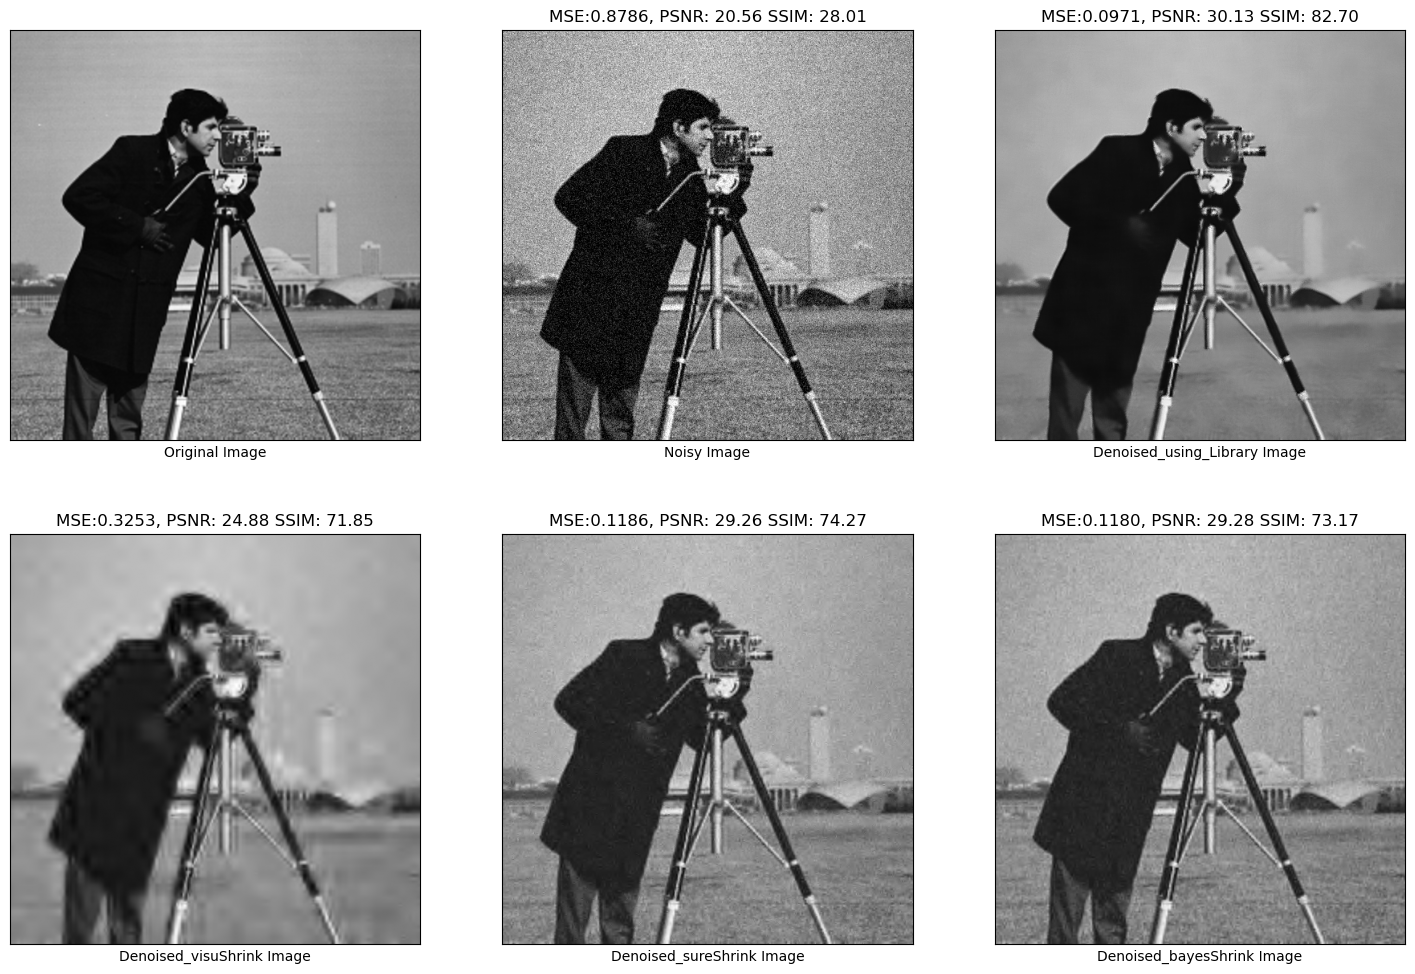

In [ ]:
mode = ['visu', 'sure', 'bayes']
denoised_img_lib = gaussianSmoothing(noisy_img, 5, 15)
# denoised_img_lib = img_as_float64(fastNlMeansDenoising((noisy_img * 255).astype(np.uint8), None, 25))

fig,axes = plt.subplots(nrows=2, ncols=3, figsize=(18,12))
axes[0, 0].imshow(img_float, cmap='gray')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])
axes[0, 0].set_xlabel("Original Image")

MSE = mse(img_float, noisy_img) * 100
SSIM = calculate_ssim(img_float, noisy_img) * 100
PSNR = psnr(img_float, noisy_img)
axes[0, 1].imshow(noisy_img, cmap='gray')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])
axes[0, 1].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
axes[0, 1].set_xlabel("Noisy Image")


MSE = mse(img_float, denoised_img_lib) * 100
SSIM = calculate_ssim(img_float, denoised_img_lib) * 100
PSNR = psnr(img_float, denoised_img_lib)
axes[0, 2].imshow(denoised_img_lib, cmap='gray')
axes[0, 2].set_xticks([])
axes[0, 2].set_yticks([])
axes[0, 2].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
axes[0, 2].set_xlabel("Denoised_using_Library Image")

for i in range(len(mode)):
    thresholded_details = applyShrink(coeffs, sigma_est, N,  mode = mode[i])
    denoised_img = pywt.waverec2(thresholded_details, wavelet="db4")

    MSE = mse(img_float, denoised_img) * 100
    SSIM = calculate_ssim(img_float, denoised_img) * 100
    PSNR = psnr(img_float, denoised_img)
    axes[1, i].imshow(denoised_img, cmap='gray')
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
    axes[1, i].set_title(f"""MSE:{MSE:.4f}, PSNR: {PSNR:.2f} SSIM: {SSIM:.2f}""")
    axes[1, i].set_xlabel(f"""Denoised_{mode[i]}Shrink Image""")


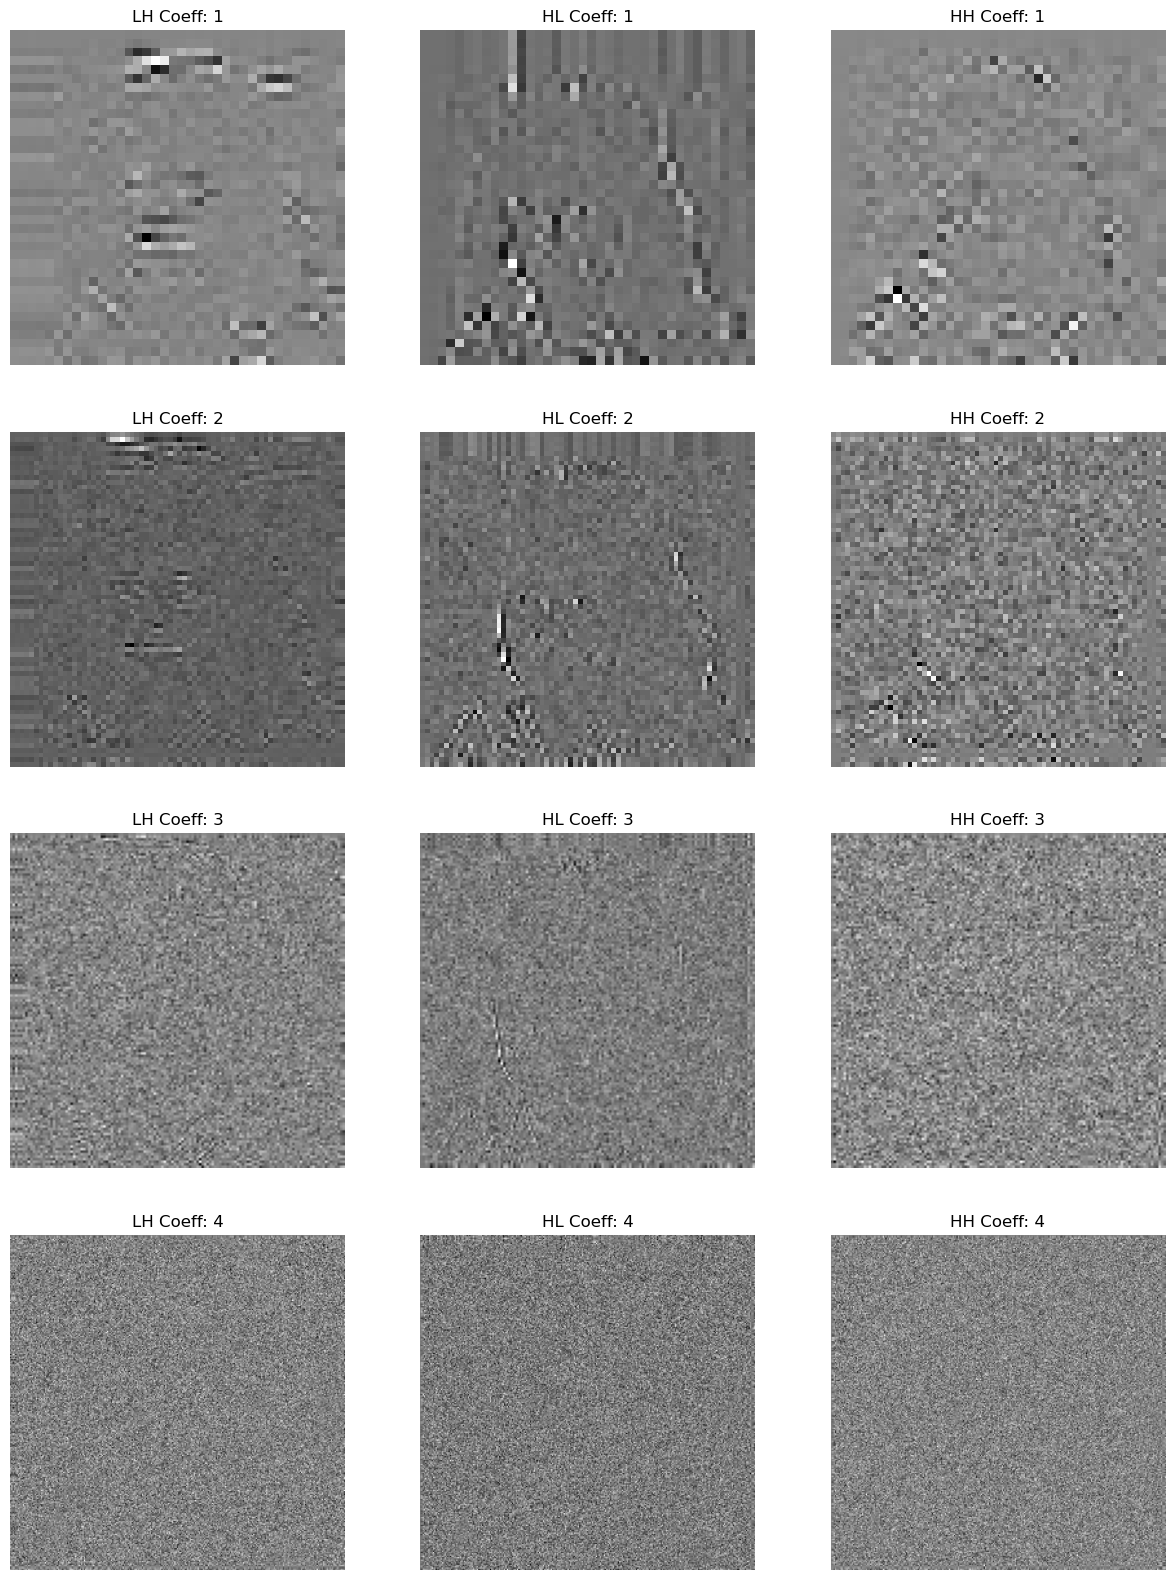

In [91]:
# Plotting Wavelet Coefficients
fig,axes = plt.subplots(nrows=4, ncols=3, figsize=(15,20))
for i in range(1, 5):
    axes[i-1, 0].imshow(coeffs[i][0], cmap='gray')
    axes[i-1, 0].axis('off')
    axes[i-1, 0].set_title(f"""LH Coeff: {i}""")

    axes[i-1, 1].imshow(coeffs[i][1], cmap='gray')
    axes[i-1, 1].axis('off')
    axes[i-1, 1].set_title(f"""HL Coeff: {i}""")

    axes[i-1, 2].imshow(coeffs[i][2], cmap='gray')
    axes[i-1, 2].axis('off')
    axes[i-1, 2].set_title(f"""HH Coeff: {i}""")
